[*********************100%***********************]  1 of 1 completed

Data downloaded.
MACD, Signal Line, and Histogram calculated.
Generating plot...


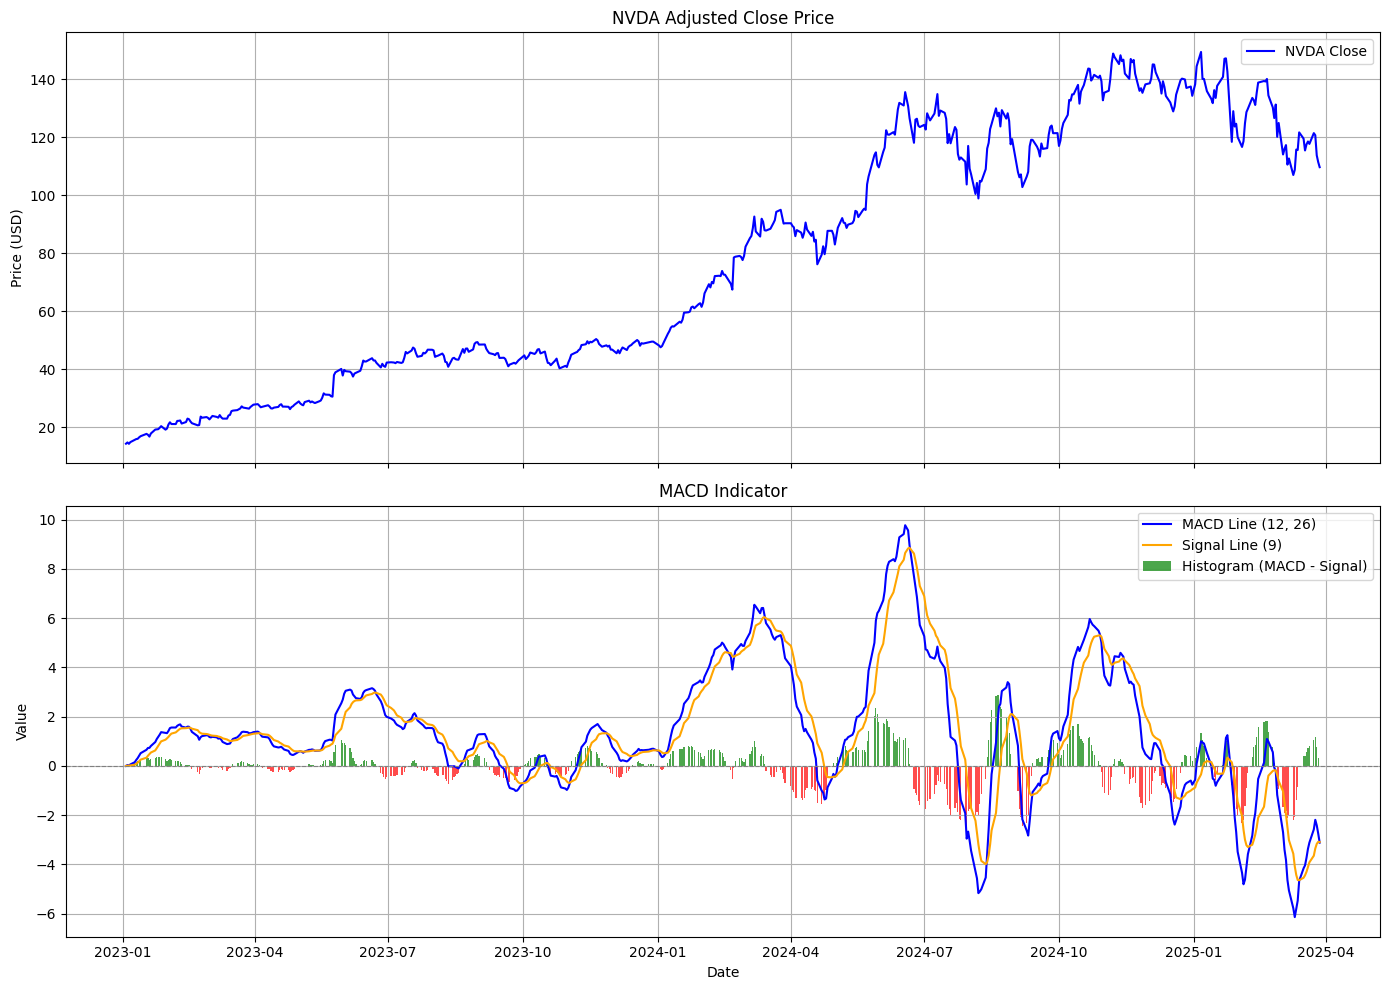

Plot displayed.


In [9]:
# Install libraries if you haven't already
# pip install yfinance pandas matplotlib

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the ticker symbol and data range
ticker = 'NVDA'
# Using a reasonable date range up to the context's current date
# Note: The market isn't open on March 31, 2025 (likely a Sunday or holiday context shift)
# Using data up to the last available trading day before March 31, 2025
start_date = '2023-01-01'
end_date = '2025-03-29' # Adjust if needed to get the latest data point

# Download historical data
print(f"Downloading {ticker} data...")
data = yf.download(ticker, start=start_date, end=end_date)
print("Data downloaded.")

# Calculate Short-term EMA (12 periods)
ema_12 = data["Close"].ewm(span=12, adjust=False).mean()

# Calculate Long-term EMA (26 periods)
ema_26 = data["Close"].ewm(span=26, adjust=False).mean()


# Calculate MACD Line
data["MACD"] = ema_12 - ema_26

# Calculate Signal Line (9-period EMA of MACD)
data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
data["Histogram"] = data["MACD"] - data["Signal_Line"]

print("MACD, Signal Line, and Histogram calculated.")

# --- Plotting ---
print("Generating plot...")

# Create figure and axes (2 plots: Price and MACD)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Adjusted Close Price
axes[0].plot(data.index, data['Close'], label='NVDA Close', color='blue')
axes[0].set_title(f'{ticker} Adjusted Close Price')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: MACD, Signal Line, and Histogram
axes[1].plot(data.index, data['MACD'], label='MACD Line (12, 26)', color='blue')
axes[1].plot(data.index, data['Signal_Line'], label='Signal Line (9)', color='orange')

# Color the histogram bars based on positive/negative values
colors = ['green' if val >= 0 else 'red' for val in data['Histogram']]
axes[1].bar(data.index, data['Histogram'], label='Histogram (MACD - Signal)', color=colors, alpha=0.7)

# Add a zero line for reference
axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.8)

axes[1].set_title('MACD Indicator')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

print("Plot displayed.")

In [13]:
# Install libraries if you haven't already
# pip install yfinance pandas pandas_ta

import yfinance as yf
import pandas as pd
import pandas_ta as ta  # Import pandas_ta

# Define the ticker symbol for NuVista Energy Ltd on TSX
ticker = "NVA.TO"

# Define the end date (using current context date)
# Fetch data up to the last trading day before or on this date
end_date = "2025-03-31"  # Using context date
# Fetch sufficient historical data for calculations (e.g., 2 years)
start_date = "2023-03-31"

print(f"Downloading daily data for {ticker} from {start_date} to {end_date}...")

interval_period = "1wk"

try:
    # Download daily historical data (interval='1d' is default)
    data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        interval=interval_period,  # Specify weekly interval
        progress=False,
    )
    if data.empty:
        print(
            f"No data downloaded for {ticker}. Check the ticker symbol or date range."
        )
    else:
        print("Data downloaded successfully.")

        # --- FIX: Flatten MultiIndex columns if they exist ---
        print("Original columns:", data.columns)  # Check the column structure
        if isinstance(data.columns, pd.MultiIndex):
            print("Detected MultiIndex columns, flattening...")
            # Assumes the standard OHLC names are in the first level
            # Adjust get_level_values(0) or (1) if needed based on the print output
            data.columns = data.columns.get_level_values(0)
            print("Flattened columns:", data.columns)
        # --- END FIX ---

        # Ensure the DataFrame index is a DatetimeIndex (usually is by default)
        data.index = pd.to_datetime(data.index)

        print("Calculating technical indicators...")

        # Check if required columns exist after potential flattening
        required_cols = [
            "High",
            "Low",
            "Close",
            "Open",
        ]  # Add 'Volume' if needed by any indicator
        if not all(col in data.columns for col in required_cols):
            raise ValueError(
                f"Missing required columns after flattening. Available: {data.columns}"
            )

        # --- Calculate Oscillators using pandas_ta ---
        # The .ta accessor is added by pandas_ta

        # Relative Strength Index (RSI)
        data.ta.rsi(length=14, append=True)  # Appends 'RSI_14' column

        # Stochastic Oscillator %K (using specified smoothing)
        data.ta.stoch(k=14, d=3, smooth_k=3, append=True)

        # Commodity Channel Index (CCI)
        data.ta.cci(length=20, append=True)  # Appends 'CCI_20_0.015' column

        # Average Directional Index (ADX)
        data.ta.adx(length=14, append=True)

        # Awesome Oscillator (AO)
        data.ta.ao(append=True)

        # Momentum (MOM)
        data.ta.mom(length=10, append=True)  # Appends 'MOM_10'

        # MACD Level (MACD Line)
        data.ta.macd(fast=12, slow=26, signal=9, append=True)

        # Stochastic RSI Fast (StochRSI %K)
        data.ta.stochrsi(rsi_length=14, length=14, k=3, d=3, append=True)

        # Williams Percent Range (%R)
        data.ta.willr(length=14, append=True)  # Appends 'WILLR_14'

        # Bull Bear Power (Requires EMA calculation first)
        data.ta.ema(length=13, append=True)  # Appends 'EMA_13'
        # Calculate Bull Power only if EMA was successfully calculated
        if "EMA_13" in data.columns:
            data["BULLP_13"] = data["High"] - data["EMA_13"]
        else:
            data["BULLP_13"] = pd.NA  # Or handle error appropriately

        # Ultimate Oscillator (UO)
        data.ta.uo(fast=7, medium=14, slow=28, append=True)

        print("Calculations complete.")
        print("\n--- Latest Oscillator Values ---")

        # Get the last row of calculated values
        latest_values = data.iloc[-1]

        # Define expected column names from pandas_ta (adjust if library changes names)
        result_cols = {
            "Relative Strength Index (14)": "RSI_14",
            "Stochastic %K (14, 3, 3)": "STOCHk_14_3_3",
            "Commodity Channel Index (20)": "CCI_20_0.015",
            "Average Directional Index (14)": "ADX_14",
            "Awesome Oscillator": "AO_5_34",
            "Momentum (10)": "MOM_10",
            "MACD Level (12, 26)": "MACD_12_26_9",
            "Stochastic RSI Fast (3, 3, 14, 14)": "STOCHRSIk_14_14_3_3",
            "Williams Percent Range (14)": "WILLR_14",
            "Bull Power (using EMA 13)": "BULLP_13",
            "Ultimate Oscillator (7, 14, 28)": "UO_7_14_28",
        }

        # Print the results, formatted to 2 decimal places like the image
        for name, col_name in result_cols.items():
            value = latest_values.get(col_name)  # Use .get for safety
            if pd.notna(value):  # Check if value is not NaN or NA
                print(f"{name:<35}: {value:.2f}")
            else:
                print(f"{name:<35}: Calculation Error or Missing Data")

        # Display the last few rows of the DataFrame with all calculated columns (optional)
        # print("\n--- Last 5 rows of data with indicators ---")
        # print(data.tail().round(2))

except Exception as e:
    print(f"An error occurred: {e}")
    # Optionally print the traceback for more detailed debugging info
    # import traceback
    # traceback.print_exc()

Data downloaded successfully.
Original columns: MultiIndex([( 'Close', 'NVA.TO'),
            (  'High', 'NVA.TO'),
            (   'Low', 'NVA.TO'),
            (  'Open', 'NVA.TO'),
            ('Volume', 'NVA.TO')],
           names=['Price', 'Ticker'])
Detected MultiIndex columns, flattening...
Flattened columns: Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Calculating technical indicators...
Calculations complete.

--- Latest Oscillator Values ---
Relative Strength Index (14)       : 65.97
Stochastic %K (14, 3, 3)           : 89.48
Commodity Channel Index (20)       : 122.59
Average Directional Index (14)     : 23.99
Awesome Oscillator                 : 1.03
Momentum (10)                      : 1.28
MACD Level (12, 26)                : 0.30
Stochastic RSI Fast (3, 3, 14, 14) : 91.49
Williams Percent Range (14)        : -18.07
Bull Power (using EMA 13)          : 0.77
Ultimate Oscillator (7, 14, 28)    : 61.74
